# Assignment 2
## Part 0: Building the network

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!

    * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.
    * Show the regular expression(s) you have built and explain in details how it works.

Importing everything that will be needed in the code in this notebook

In [1]:
import urllib
import json
import re
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import math
from wordcloud import WordCloud, STOPWORDS
import imageio
import csv
import community as community_louvain
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#### The following code shows how the Zelda network was built.

Creating the queries for each page of character groups (Allies, enemies and bosses)

In [2]:
baseurl = 'https://zelda.fandom.com/api.php?'
action = 'action=query'
title_allies = 'titles=Characters_in_Breath_of_the_Wild'
title_enemies = 'titles=Enemies_in_Breath_of_the_Wild'
title_bosses = 'titles=Bosses_in_Breath_of_the_Wild'
content='prop=revisions&rvprop=content&rvslots=*'
dataformat='format=json'

query_allies = '%s&%s&%s&%s&%s' % (baseurl,action,title_allies,content,dataformat)
query_enemies = '%s&%s&%s&%s&%s' % (baseurl,action,title_enemies,content,dataformat)
query_bosses = '%s&%s&%s&%s&%s' % (baseurl,action,title_bosses,content,dataformat)

Creating a regular expression pattern to extract all character names from the character pages. 
This reg-ex pattern matches any word, whitespace, dashes, round brackets and apostrophes following "{{Term|BotW|" and preceding "|link". Excluding |display= some characters }}

In [3]:
pattern = "(?<=\{\{Term\|BotW\|)[\-\w\s\(\)\' ]+(?=\|link(?:\|display=.*?|\}\}))"

Fetching all ally, enemy and boss names from the pages.

In [4]:
response_allies = urllib.request.urlopen(query_allies)
html_allies = response_allies.read().decode('utf-8')
match_allies = re.findall(pattern, html_allies)

response_enemies = urllib.request.urlopen(query_enemies)
html_enemies = response_enemies.read().decode('utf-8')
match_enemies = re.findall(pattern, html_enemies.partition('==Traps==')[0])

response_bosses = urllib.request.urlopen(query_bosses)
html_bosses = response_bosses.read().decode('utf-8')
new_bosses = re.sub(r'\(\{\{Term\|BotW\|[\-\w\s\(\)]+\|link\}\}\)', '', html_bosses)
match_bosses = re.findall(pattern, new_bosses)

Adding all character names and their roles to dataframes

In [5]:
df1 = pd.DataFrame({ 'Name' : match_allies,
                     'Role' : 'Ally'})

df2 = pd.DataFrame({ 'Name' : match_enemies,
                     'Role' : 'Enemy'})

df3 = pd.DataFrame({ 'Name' : match_bosses,
                     'Role' : 'Boss'})

Merging the three data frames into a single data frame

In [6]:
df_temp = df1.append(df2,ignore_index=True)
df = df_temp.append(df3,ignore_index=True)

Dropping character duplicates

In [7]:
all_characters = df.drop_duplicates(subset=['Name'],keep='last')

Next up is loading each character page and saving to a txt file

In [10]:
characters_path = './character_pages/'


for name in df.Name:
    new_name = name.replace(' ','_')
    title_characters = 'titles='+new_name

    query_characters = '%s&%s&%s&%s&%s' % (baseurl,action,title_characters,content,dataformat)
    response_characters = urllib.request.urlopen(query_characters)
    characters_text = response_characters.read().decode('utf-8')

    file_name = new_name + '.txt'
    text_file = open(characters_path+file_name, "w")
    text_file.write(characters_text)
    text_file.close()  

Creating a directed graph and adding in a node for each character

In [11]:
G = nx.DiGraph()
G.add_nodes_from(list(all_characters.Name))

Next is adding links between characters based on references in character pages

In [12]:
def isCharacter(link):   
    if link in list(all_characters['Name']):
        return True
    else:
        return False  

Adding race and gender information for each character on the corresponding network node

Finding the race information:
* Start by using regular expressions to match everything follwing "race= " until the next linebreak and storing in the variable "race"
* Then extract the race from the race variable by using race_pattern_1 and race_pattern_2
* race_pattern_1 matches strings on the format {{Term|\*any word\*|\*Race Name\*|link}} and extracts the \*Race Name\* string
* race_pattern_2 matches strings on the format [[\*Race Name\*]] and extracts the \*Race Name\* string

Finding the gender information:
* Matching either Male or Female from the character text

If no information is found the gender or race is set to "Unknown"

In [13]:
#Loop through all character names to find race and gender for each character
for name in df.Name:
    new_name = name.replace(' ','_')
    with open('./character_pages/'+new_name+'.txt') as f:
            text = f.read()
            f.close() 

#Using regular expressions to extract the characters' races and genders
    race = re.findall("race= ([\s\S]*)", text)
    gender = re.findall("Female|Male", text)
    if race:
        race = race[0].split('\\n')[0]
        race = race.split('<')[0]
        if not race.isalpha():
            race_pattern_1 = "(?:\{\{Term\|.*?\|)(.*?)(?:\|link|)\}\}"
            race_pattern_2 = "(?:\[\[)(.*?)(?:\]\])"
            race1 = re.findall(race_pattern_1,race) 
            race2 = re.findall(race_pattern_2,race)
            race = race1 + race2
        else:
            tmp_race = race
            race = []
            race.append(tmp_race)
    if not race:
        race = ['Unknown']
    if not gender:
        gender = ['Unknown']
#Adding the race, gender and role as attributes to corresponding node
    attrs = {name: {"race": race, "gender": gender, "role": all_characters[all_characters['Name']==name]['Role'].to_string(index=False)}}
    nx.set_node_attributes(G, attrs)

Now it's time to add links between nodes based off references in character pages.

To find the character references in the pages two reg-ex patterns are used:
* pattern1 matches everything between [[ and ]] except | and the following text as well as # and the following text
* pattern2 matches everything between {{Term|\*text\*| and } except |link or |display=\*following text\*

In [14]:
#Create two patterns which should cover all instances of relevant links in the pages
pattern1 = '\[\[(.*?)(?:\|.*?|\#.*?)?\]\]'
pattern2 = '\{\{Term\|.*?\|(.*?)(?:\|link|\|link\|display=.*?)?\}+'

#Loop through all character names in our dataframe 
for name in df.Name:
    new_name = name.replace(' ','_')

    with open('./character_pages/'+new_name+'.txt') as f:
        text = f.read()
        f.close() 

    #Create a list of all links for this character page
    links = []
    links = re.findall(pattern1,text) + re.findall(pattern2,text)

    #Remove duplicates from the list
    links = list(set(links))

    #Loop through links and add node connection if link is a character
    for link in links:
        if isCharacter(link):
            G.add_edge(name, link)

Extracting the giant connected component and saving node information to a data frame to be used in the rest of the report.

In [15]:
#Extracting giant component
G_gc = G.subgraph(max(nx.weakly_connected_components(G), key=len)).copy()

gc_characters = pd.DataFrame({ 'Name' : G_gc.nodes()})

## Part 1: Network visualization and basic stats

Visualize the network (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you've already generated the BotW network and extracted the giant connected component. Use the GCC to report the results.

Exercise 1a: Stats (see lecture 4 and 5 for more hints)

    * What is the number of nodes in the network?
    * What is the number of links?
    * Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
    * Who are the top 5 most connected allies (again in terms of in/out-degree)?
    * Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?
    * Plot the in- and out-degree distributions.
        - What do you observe?
        - Can you explain why the in-degree distribution is different from the out-degree distribution?
    * Find the exponent of the degree distribution (by using the powerlaw package) for the in- and out-degree distribution. What does it say about our network?
    * Compare the degree distribution of the undirected graph to a random network with the same number of nodes and probability of connection p. Comment your results.


### Exercise 1a: Stats

#### Q: What is the number of nodes in the network?

In [16]:
print('There are',G_gc.number_of_nodes(),'nodes in the giant connected component')

There are 535 nodes in the giant connected component


#### Q: What is the number of links?

In [17]:
print('There are',G_gc.number_of_edges(),'links in the giant connected component')

There are 2052 links in the giant connected component


#### Q: Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees)

In [18]:
#Adding information regarding degrees for each node in the giant component character data frame
for node in G_gc.nodes():
    gc_characters.loc[gc_characters.Name == node, 'Role'] = G_gc.nodes[node]['role']
    gc_characters.loc[gc_characters.Name == node, 'In-degrees'] = G_gc.in_degree[node]
    gc_characters.loc[gc_characters.Name == node, 'Out-degrees'] = G_gc.out_degree[node]
    gc_characters.loc[gc_characters.Name == node, 'Total-degrees'] = G_gc.degree[node]

#Fetching information regarding the top connected characters
top_in = gc_characters.loc[gc_characters['In-degrees'] == gc_characters['In-degrees'].max()].Name.to_string(index=False)
top_out = gc_characters.loc[gc_characters['Out-degrees'] == gc_characters['Out-degrees'].max()].Name.to_string(index=False).split()

print('The top connected In-degree character is',top_in)
print('The top connected Out-degree characters are',top_out[0],'and',top_out[1])

The top connected In-degree character is Link
The top connected Out-degree characters are Traysi and Moblin


#### Q: Comment on your findings. Is this what you would have expected?

It was expected that Link would have a high in-degree value since he is the main character and the story revolves around him.
When inspecting Traysi's Wiki it became clear why she has sush a high our-degree value, since she is an investigative journalist she interacts with a lot of other characters and therefore a lot of people are mentioned in her Wiki page.
Moblin came as a surprise but when inspecting his Wiki page there are a lot of characters mentioned as different variants of the species are being referenced.

#### Q: Who are the top 5 most connected allies (again in terms of in/out-degree)?

In [19]:
top_allies_in = gc_characters[gc_characters['Role'] == 'Ally'].sort_values(by='In-degrees',ascending=False).head(5).Name
top_allies_out = gc_characters[gc_characters['Role'] == 'Ally'].sort_values(by='Out-degrees',ascending=False).head(5).Name

print('The top 5 in-degree connected allies are:') 
print(list(top_allies_in))
print('\nThe top 5 out-degree connected allies are:') 
print(list(top_allies_out))

The top 5 in-degree connected allies are:
['Link', 'Hylia', 'Princess Zelda', 'Riju', 'Mipha']

The top 5 out-degree connected allies are:
['Traysi', 'Dorian', 'Daruk', 'Link', 'Mipha']


#### Q: Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?

In [20]:
top_enemies_in = gc_characters[gc_characters['Role'] != 'Ally'].sort_values(by='In-degrees',ascending=False).head(5).Name
top_enemies_out = gc_characters[gc_characters['Role'] != 'Ally'].sort_values(by='Out-degrees',ascending=False).head(5).Name

print('The top 5 in-degree connected enemies are:')
print(list(top_enemies_in))
print('The top 5 out-degree connected enemies are:')
print(list(top_enemies_out))

The top 5 in-degree connected enemies are:
['Calamity Ganon', 'Bokoblin', 'Lizalfos', 'Moblin', 'Fire-Breath Lizalfos']
The top 5 out-degree connected enemies are:
['Moblin', 'Lizalfos', 'Stalizalfos', 'Windblight Ganon', 'Silver Lizalfos']


#### Plot the in- and out-degree distributions

In [21]:
in_degrees = gc_characters['In-degrees']
out_degrees = gc_characters['Out-degrees']

Plotting in-degree distribution

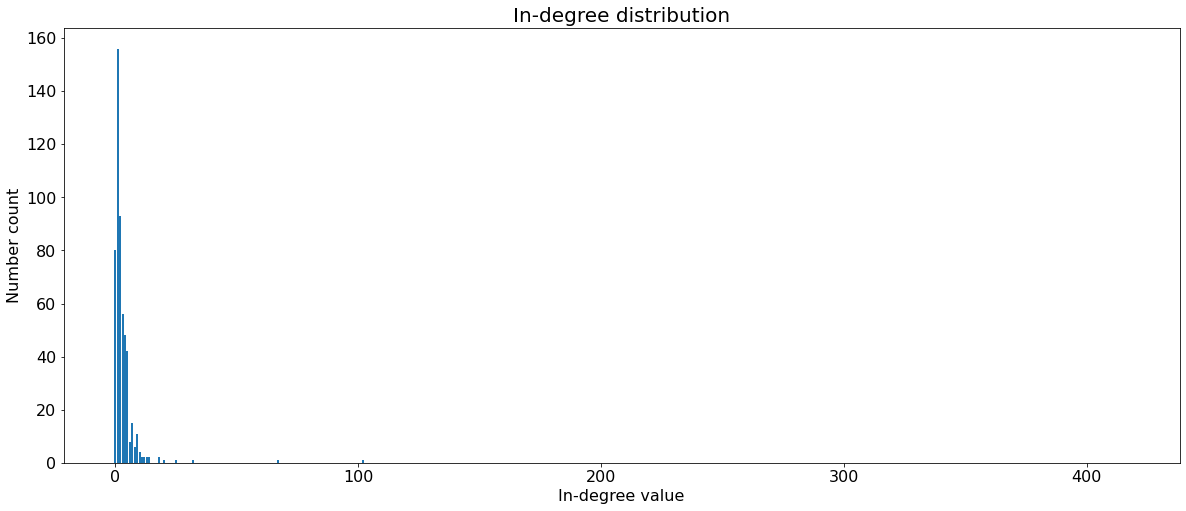

In [22]:
v_in = np.arange(min(in_degrees)-0.5, max(in_degrees)+0.5, 1)
hist_in, bin_edges_in = np.histogram(in_degrees,bins=v_in)

mean_in = []
for j in range(len(bin_edges_in)-1):
    mean_in.append((bin_edges_in[j]+bin_edges_in[j+1])/2)

plt.figure(figsize=(20,8))
plt.bar(mean_in, hist_in)
plt.title('In-degree distribution',fontsize=20)
plt.ylabel('Number count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
_ = plt.xlabel('In-degree value',fontsize=16)

Since there are few nodes with much higher in-degrees, it is hard to visualise the distribution of the other nodes, therefore it was decided to remove those outliers.

In [23]:
new_in_degrees = gc_characters.loc[gc_characters['In-degrees'] < 25, 'In-degrees']

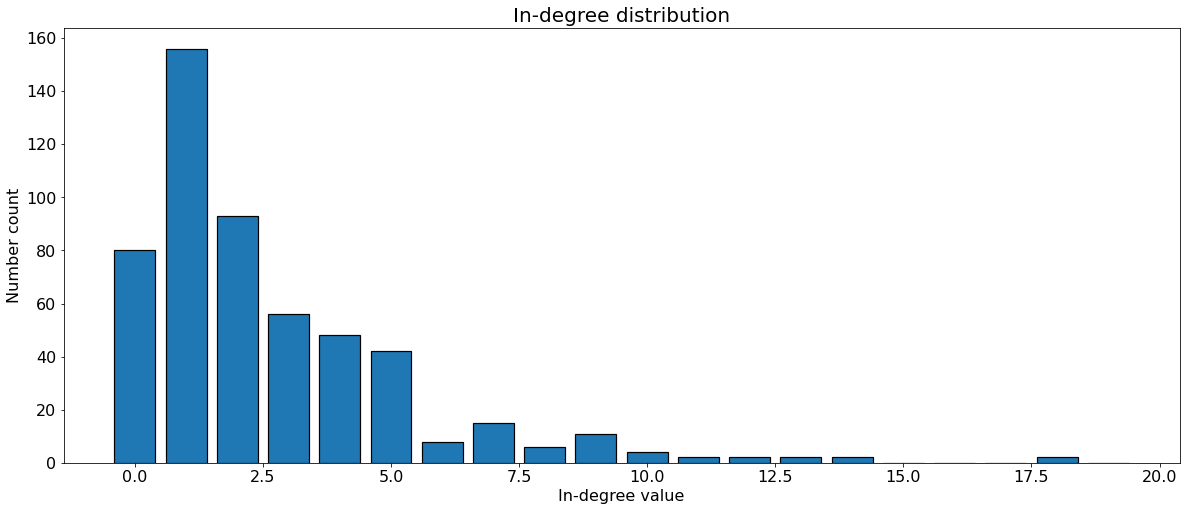

In [24]:
v_in = np.arange(min(new_in_degrees)-0.5, max(new_in_degrees)+0.5, 1)
hist_in, bin_edges_in = np.histogram(new_in_degrees,bins=v_in)

mean_in = []
for j in range(len(bin_edges_in)-1):
    mean_in.append((bin_edges_in[j]+bin_edges_in[j+1])/2)

plt.figure(figsize=(20,8))
plt.bar(mean_in, hist_in, edgecolor='black', linewidth=1.2)
plt.title('In-degree distribution',fontsize=20)
plt.ylabel('Number count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
_ = plt.xlabel('In-degree value',fontsize=16)

The graph shows that the majority of the nodes have an in-degree between 0 and 2, which means that most characters are only referenced by a very small number of other characters. With an exception of the outlier characters that are referenced by a large number of other characters, those are most likely one of the main characters or have a big presence in the story.

Plotting out-degree distribution

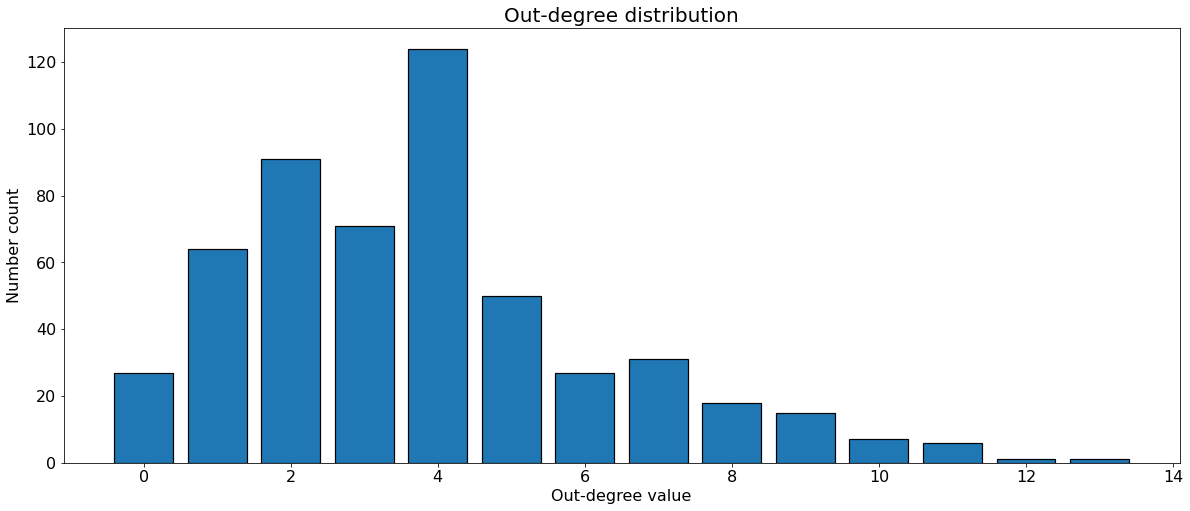

In [25]:
v_out = np.arange(min(out_degrees)-0.5, max(out_degrees)+0.5, 1)
hist_out, bin_edges_out = np.histogram(out_degrees,bins=v_out)

mean_out = []
for j in range(len(bin_edges_out)-1):
    mean_out.append((bin_edges_out[j]+bin_edges_out[j+1])/2)

plt.figure(figsize=(20,8))
plt.bar(mean_out, hist_out, edgecolor='black', linewidth=1.2)
plt.title('Out-degree distribution',fontsize=20)
plt.ylabel('Number count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
_ = plt.xlabel('Out-degree value',fontsize=16)

The graph shows that most characters have an out-degree of 2 - 4 and that there are no characters with very high values. Comparing this graph to the in-degree distribution it is clear that the out-degree is much more equally distributed than the in-degree. 

#### Q: What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?

There are some much bigger degrees in the in-degree distribution. Since the out-degrees come from each character page the out-degrees are much more limited than the in-degrees which is the number of pages that reference the character. The main characters in the story are referenced a lot by other characters while they are not necessarily referencing a lot of other characters.

#### Find the exponent of the degree distribution (by using the powerlaw package) for the in- and out-degree distribution. 

In [26]:
all_in_degrees = []
all_out_degrees = []
for node in G_gc.nodes():
    all_in_degrees.append(G_gc.in_degree(node))
    all_out_degrees.append(G_gc.out_degree(node))
    

print("In degrees: ",round(powerlaw.Fit(all_in_degrees).alpha,4))
print("Out degrees: ",round(powerlaw.Fit(all_out_degrees).alpha,4))

Calculating best minimal value for power law fit
In degrees:  3.355
Calculating best minimal value for power law fit
Out degrees:  4.4661


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


#### Q: What does the exponent of the degree distribution say about our network?

The exponents are larger than 3 for both the in and out degrees of the network. If the degree exponent is larger than 3 than the network follows the small world regime, although for small N the distances between nodes is comparable with scale free networks with a different exponent.

#### Compare the degree distribution of the undirected graph to a random network with the same number of nodes and probability of connection p. Comment your results.

In [27]:
all_k = []
nr_nodes = G_gc.number_of_nodes()
for node in G_gc.nodes():
    all_k.append(G_gc.degree(node))
av_k = np.mean(all_k)

UG_gc = G_gc.to_undirected()

#Creating the random network
p = np.mean(all_k)/(nr_nodes - 1)
G_rand = nx.gnp_random_graph(nr_nodes, p)

all_k_rand = []
for node in G_rand.nodes():
    all_k_rand.append(G_rand.degree(node))

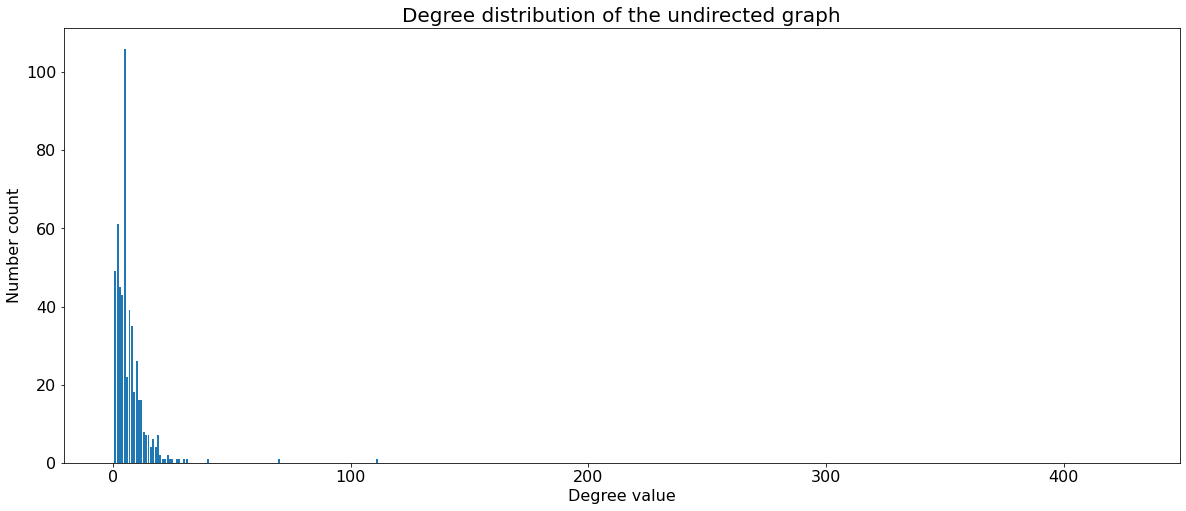

In [28]:
v_out = np.arange(min(all_k)-0.5, max(all_k)+0.5, 1)
hist_out, bin_edges_out = np.histogram(all_k,bins=v_out)

mean_out = []
for j in range(len(bin_edges_out)-1):
    mean_out.append((bin_edges_out[j]+bin_edges_out[j+1])/2)

plt.figure(figsize=(20,8))
plt.bar(mean_out, hist_out)
plt.title('Degree distribution of the undirected graph',fontsize=20)
plt.ylabel('Number count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
_ = plt.xlabel('Degree value',fontsize=16)

Since there are few nodes with much higher degrees, it is hard to visualise the distribution of the other nodes, therefore it was decided to remove those outliers.

In [29]:
new_all_k = []
for k in all_k:
    if k < 25:
        new_all_k.append(k)

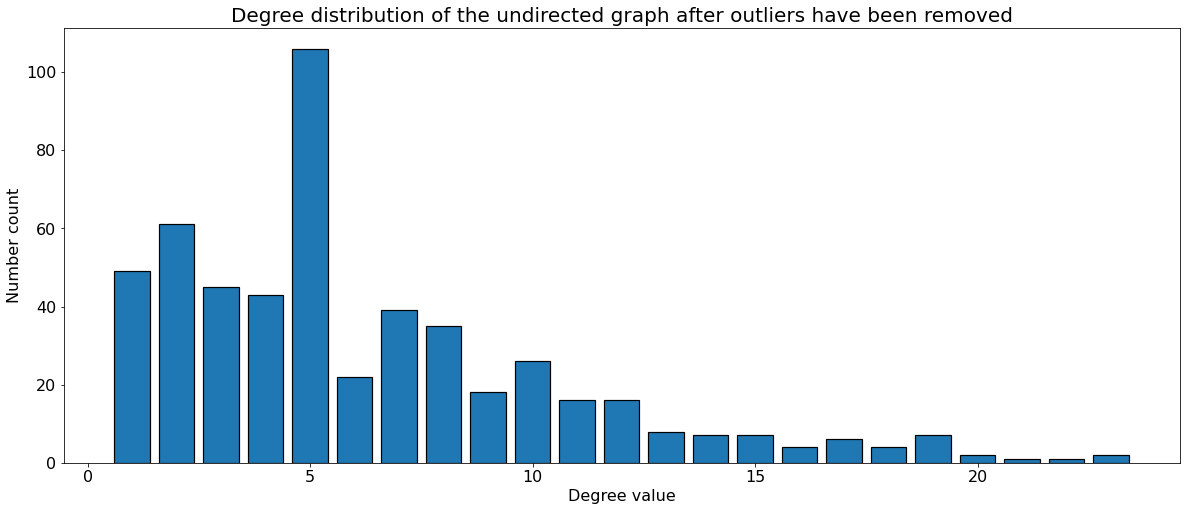

In [30]:
v_out = np.arange(min(new_all_k)-0.5, max(new_all_k)+0.5, 1)
hist_out, bin_edges_out = np.histogram(new_all_k,bins=v_out)

mean_out = []
for j in range(len(bin_edges_out)-1):
    mean_out.append((bin_edges_out[j]+bin_edges_out[j+1])/2)

plt.figure(figsize=(20,8))
plt.bar(mean_out, hist_out, edgecolor='black', linewidth=1.2)
plt.title('Degree distribution of the undirected graph after outliers have been removed',fontsize=20)
plt.ylabel('Number count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
_ = plt.xlabel('Degree value',fontsize=16)

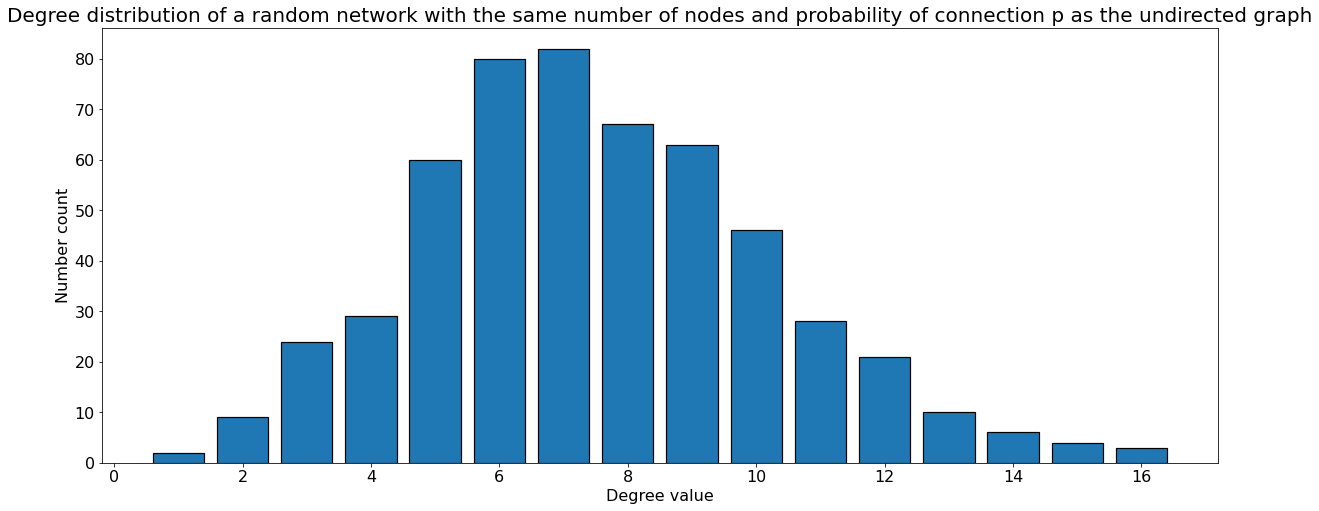

In [31]:
v_out = np.arange(min(all_k_rand)-0.5, max(all_k_rand)+0.5, 1)
hist_out, bin_edges_out = np.histogram(all_k_rand,bins=v_out)

mean_out = []
for j in range(len(bin_edges_out)-1):
    mean_out.append((bin_edges_out[j]+bin_edges_out[j+1])/2)

plt.figure(figsize=(20,8))
plt.bar(mean_out, hist_out, edgecolor='black', linewidth=1.2)
plt.title('Degree distribution of a random network with the same number of nodes and probability of connection p as the undirected graph',fontsize=20)
plt.ylabel('Number count',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
_ = plt.xlabel('Degree value',fontsize=16)

Comparing the degree distributions it seems that the Zelda graph has more equally distributed degree values, with the exception of degree value 5 which clearly has the most nodes by far. Most of the nodes in the Zelda network also have lower degrees than in the random network. The random graph seems to follow more of a normal distribution where most number of degree values are from 7 to 8.

### Exercise 1b: Visualization

Exercise 1b: Visualization (see lecture 5 for more hints)

    * Create a nice visualization of the total (undirected) network:
        - Color nodes according to the role;
        - Scale node-size according to degree;
        - Get node positions based on the Force Atlas 2 algorithm;
        - Whatever else you feel like that would make the visualization nicer.
    * Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?

#### Create a nice visualization of the total (undirected) network:

In [32]:
degree_list=list(UG_gc.degree())
nodes, degree = map(list, zip(*degree_list))
roles = nx.get_node_attributes(UG_gc,'role')

color_roles = {'Ally': [228/256,179/256,76/256], 'Enemy': [206/256,55/256,92/256], 'Boss': [98/256,195/256,236/256]}


Creating a color map and a size map

In [33]:
colormap = []
sizemap = []
for node in nodes:
    colormap.append(color_roles[roles[node]])
    sizemap.append(UG_gc.degree(node)*5 + 4)

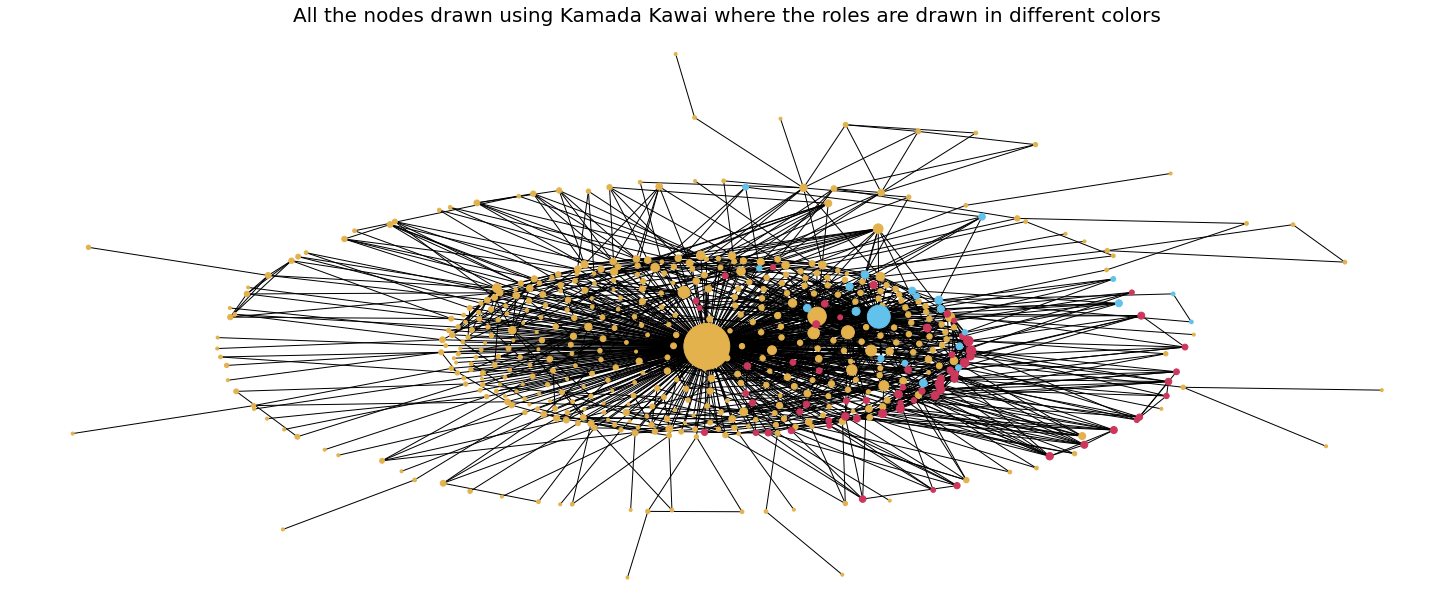

In [34]:
plt.figure(figsize=(20,8))
nx.draw_kamada_kawai(
    UG_gc, 
    nodelist=nodes, 
    node_size=sizemap,
    node_color=colormap
)
_ = plt.title('All the nodes drawn using Kamada Kawai where the roles are drawn in different colors',fontsize=20)

Visualization of the Zelda network giant connected component where each node is colored according to it's role. Allies are colored yellow, enemies are colored red and bosses are blue. All node sizes are proportional to the node's degree.

100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 322.28it/s]


BarnesHut Approximation  took  1.64  seconds
Repulsion forces  took  4.01  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.23  seconds


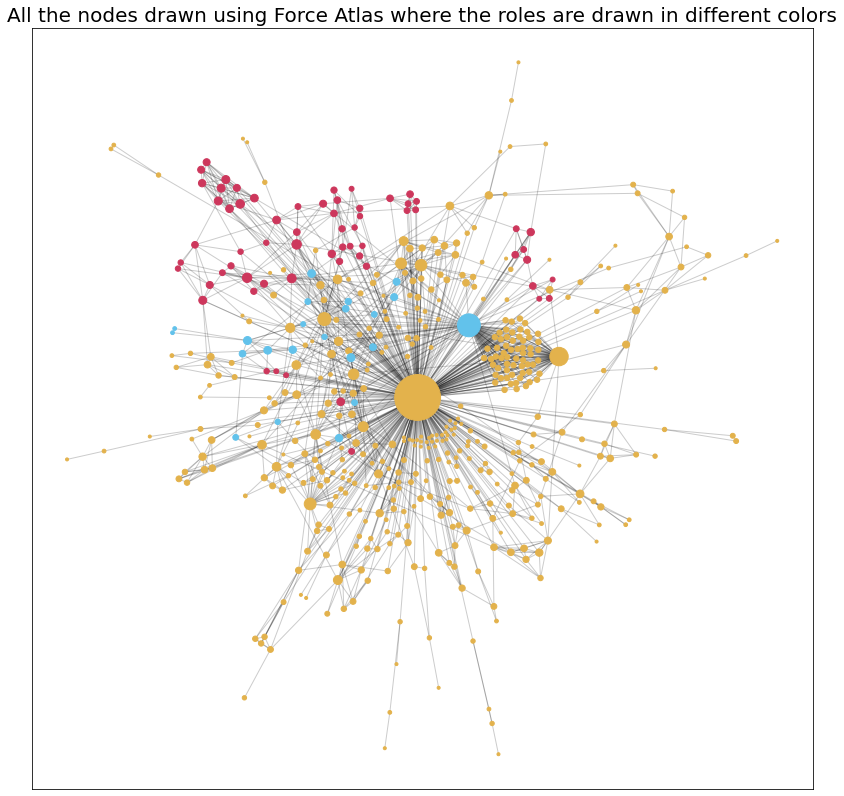

In [35]:
from fa2 import ForceAtlas2
plt.figure(figsize=(14,14))
forceatlas2 = ForceAtlas2(edgeWeightInfluence=1, scalingRatio=2)
positions = forceatlas2.forceatlas2_networkx_layout(UG_gc,pos=None,iterations=2000)
nx.draw_networkx_nodes(UG_gc,
                       positions,
                       node_color=colormap,
                       node_size=sizemap)
nx.draw_networkx_edges(UG_gc,positions,edge_color="black",alpha=0.2)
_ = plt.title('All the nodes drawn using Force Atlas where the roles are drawn in different colors',fontsize=20)

A better visualization of the Zelda network. In this graph each node is more visible as well as the connections between nodes. Here node clusters also become more clear.

#### Q: Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?

In [36]:
#Printing top connected nodes
gc_characters.sort_values(by='Total-degrees', ascending=False).head(3)

,Name,Role,In-degrees,Out-degrees,Total-degrees
32,Link,Ally,418.0,10.0,428.0
533,Calamity Ganon,Boss,102.0,9.0,111.0
25,Hylia,Ally,67.0,3.0,70.0


There is one large node in the middle that seems to have the most connections by far and can therefore be said to have a privileged position in the network. It can be assumed that one is Link, since he has the largest degree. There can also be seen two fairly large nodes, it can be assumed that the larger of the two is Galamaty Canon, while the other is Hylia.

## Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the ZeldaWiki pages.

Starting by preparing everything that will be needed in the for loop below. The stop words, reg-ex pattern that will be used to exclude the headers, the lemmatizer that will be used and creating vectors to store all the words for each race.

In [37]:
stops = list(set(stopwords.words("english")))
header_pattern = '==+.*?==+'

wnl = nltk.WordNetLemmatizer()

hylian = [] 
zora = [] 
goron = []
gerudo = []
rito = []

Creating a list of all races in the network

In [38]:
races_list = []
for node in G_gc.nodes:
    races_list.append(G_gc.nodes[node]['race'][0])

Creating dictionary where the keys are the unique races and the values for each key is an array of words.

In [39]:
races = {}

for race in list(set(races_list)):
    races[race] = []

Let's now run through a loop that looks at each character (node) in the network and get read the character text file. All headers are filtered out using regular expressions and the header_pattern declared in the cell above. The reg-ex pattern works by searching for some text enclosed in two or more equal signs. (i.e ==\*Some text\*==)

In [40]:
for node in G_gc.nodes:
    name = node.replace(' ','_')
    with open('./character_pages/'+name+'.txt') as f:
        text = f.read()
        f.close() 
    
    #Filtering out the headers of sections
    new_text = re.sub(header_pattern,'',text)

    #Excluding character names
    for n in G.nodes:
        n_plural = n+'s'
        new_text = re.sub(n,'',new_text)
        new_text = re.sub(n_plural,'',new_text)

    #Tokenizing the text with WordPunctTokenizer()
    tokens = []
    tokens = WordPunctTokenizer().tokenize(new_text)

    #For each token, only include if it's not punctuation, if it's not a stopword and if it is longer than one letter when lemmatized
    #Saving results in the corresponding race array in dictionary, results are saved in lowercase and lemmatized.
    for token in tokens:
        if token.isalpha() and token.lower() not in str(stops).lower() and len(wnl.lemmatize(token.lower())) != 1:
            node_race = G_gc.nodes[node]['race'][0]
            races[node_race].append(wnl.lemmatize(token.lower()))


Next up is finding the number of times each word is repeated for each race. First a data frame is created to store the information regarding each word for each race. Then the count information is added to the dataframe, for each word in each race.

In [41]:
race_df = pd.DataFrame({'word':[],'count':[],'race':[]})
for key in races:
    for w in list(set(races[key])):
        new_row = {'word':w, 'count':races[key].count(w), 'race':key}
        race_df = race_df.append(new_row, ignore_index=True)

Now let's compute the idf value of each word in the top 5 races. To do that we loop through each word in the data frame, find the number of documents the word appears in (doc_nums) and calculate the idf using the formula log(total number of docs/doc_nums)

The idf value is added to the dataframe as well as the tc-idf (which is the word count * idf)

In [42]:
#Total number of races
n = len(list(set(races_list))) 
top_races = ['Hylian','Zora','Goron','Gerudo','Rito']

for w in race_df.loc[race_df['race'].isin(top_races) == True, 'word']:
    doc_nums = race_df.loc[race_df.word == w,'word'].count()
    race_df.loc[race_df.word == w, 'idf'] = math.log10(n/doc_nums)
race_df['tc-idf'] = race_df['count'] * race_df['idf']

To draw the word clouds we first need to create lists of words for each race. The lists contain each word for each corresponding race repeated as many times as the tc-idf rounded up. 

In [43]:
wc_hylian = []
wc_zora = []
wc_goron = []
wc_gerudo = []
wc_rito = []

for index, row in race_df.iterrows():
    if row['race'] == 'Hylian':
        wc_hylian += [row['word']]*math.ceil(row['tc-idf'])
    elif row['race'] == 'Zora':
        wc_zora += [row['word']]*math.ceil(row['tc-idf'])
    elif row['race'] == 'Goron':
        wc_goron += [row['word']]*math.ceil(row['tc-idf'])
    elif row['race'] == 'Gerudo':
        wc_gerudo += [row['word']]*math.ceil(row['tc-idf'])
    elif row['race'] == 'Rito':
        wc_rito += [row['word']]*math.ceil(row['tc-idf'])

Drawing the wordcloud for each race.

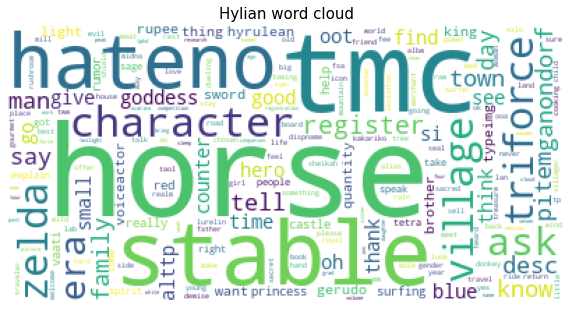

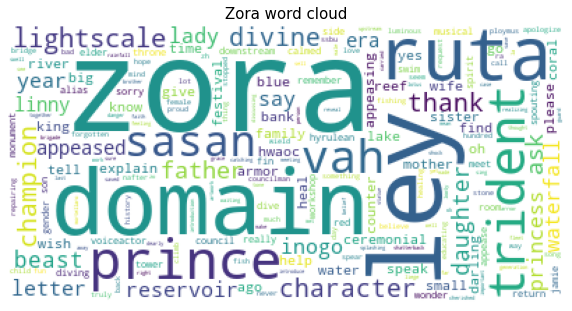

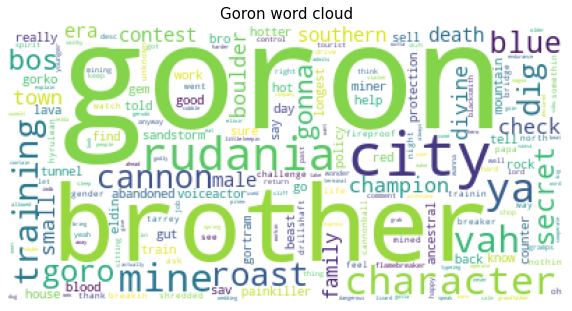

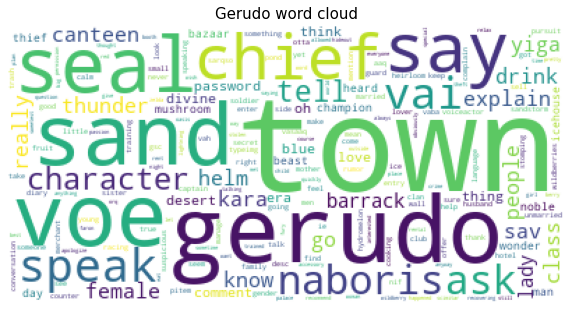

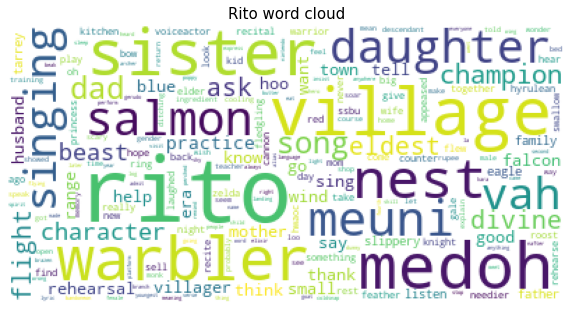

In [44]:
wcs = [wc_hylian,wc_zora,wc_goron,wc_gerudo,wc_rito]
races = ['Hylian','Zora','Goron','Gerudo','Rito']

for i in range(len(wcs)):
    wordcloud = WordCloud(
                          background_color='WHITE',
                          collocations=False
                         ).generate(' '.join(map(str,wcs[i])))

    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud)
    plt.title(races[i]+' word cloud',fontsize=15)
    plt.axis('off')
    plt.show()

When looking at the word cloud for each race it is clear right away that the race name is a word frequently used among characters in that race. This is true for all of the races except for Hylian. 

*Hylian*

The most prominent words in the Hylian word cloud are words like tmc, horse, hateno, stable and triforce. The word Hateno comes from the Hateno village, a permanent Hylian settlement, which is why it is referenced a lot in relation to Hylians. Triforce is a golden relic of power possessed by Ganondorf which is the main antagonist in the story. The Hylian Princess Zelda was also destined to be the keeper of the Triforce of wisdom. The reference to horses and stables could be connected to the fact that hylians travel on horseback and have horses. TMC is a gameboy game often referenced in the character pages. 

*Zora*

The Zora word cloud is characterized by words like Zora, trident, ruta and domain. Ruta is a giant machine that resembles an elephant, it was piloted by Mipha, the Zora champion, which can explain why it is referenced so many times. Trident is a weapon and is higly referenced by the Zora community since it is used ceremonially in the Zora's Champion Festival. The word domain most likely comes from Zora's Domain, which is the land of the Zoras

*Goron*

The most referenced words by the Goron race are rudania, goron, brother and city. Rudania is a giant machine Salamander which was operated by the Goron champion Daruk. The word brother could be a reference to the Goron Blood Brothers and the word city is most likely referencing Goron City which is the home of the Gorons.

*Gerudo*

The most referenced words by the Gerudo race are gerudo, sand, seal, town and voe. The Gerudo's live in the Gerudo Desert, which could explain the references to the word sand. That, along with the word seal, could also be referencing the sand seals that are native to the Gerudo Desert. The word voe means man in Gerudo language and is often used and the word town is most likely referencing Gerudo Town which is the main settlement of the Gerudo Desert.

*Rito*

The Rito word cloud has most references to the words rito, village, medoh, sister and warbler. Rito village is the home of the Rito race and the Warbler's nest is located close to the village. Medoh is a divine beast that resembles an eagle, he served as a protector of the Rito people. The word sister is most likely connected to the rescue mission Link went on to save the Rito Quill's sister after which Link was first taken into the Rito headquarters.

# Part 3: Communities and TF-IDF

Find communities and compute their associated TF-IDF (from lecture 7 and 8).
Here's what you need to do:

    * Explain the Louvain algorithm and how it finds communities in a newtork.
    * Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works)
Comment your results:

    * How many communities did you find in total?
    * Compute the value of modularity with the partition created by the algorithm.
    * Plot the distribution of community sizes.
For the 5 largest communities, create TF-IDF based rankings of words in each community.

    * There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.
    * List the 5 top words for each community according to TF.
    * List the 5 top words for each community accourding to TF-IDF. Are these words more descriptive of the community than just the TF? Justify your answer.

#### Q: Explain the Louvain algorithm and how it finds communities in a newtork.

The Louvain algorithm is used to identify communities in large networks and runs in time O(n log n). It is a greedy optimization that optimises the modularity of a partition in two phases.
    
    * It optimises modularity locally
    * A new network is created basen on the partition obtained in the phase before where each community in the partition becomes a node in the network. This is done repetitively until a maximum of modularity is attained.

https://perso.uclouvain.be/vincent.blondel/research/louvain.html

#### Q:  Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works)

The algorithm used was Louvain

Generating the communities using the Louvain algorithm

In [45]:
partition = community_louvain.best_partition(UG_gc)

#### Q: How many communities did you find in total?

In [46]:
all_partitions = []

for node in partition:
    all_partitions.append(partition[node])
communities = list(set(all_partitions))
print('The number of communities found in total is: ', len(communities))

The number of communities found in total is:  21


#### Q: Compute the value of modularity with the partition created by the algorithm.

In [47]:
print('The modularity with the partition created by the algorithm is: ', round(community_louvain.modularity(partition, UG_gc), 4))

The modularity with the partition created by the algorithm is:  0.617


#### Q: Plot the distribution of community sizes.

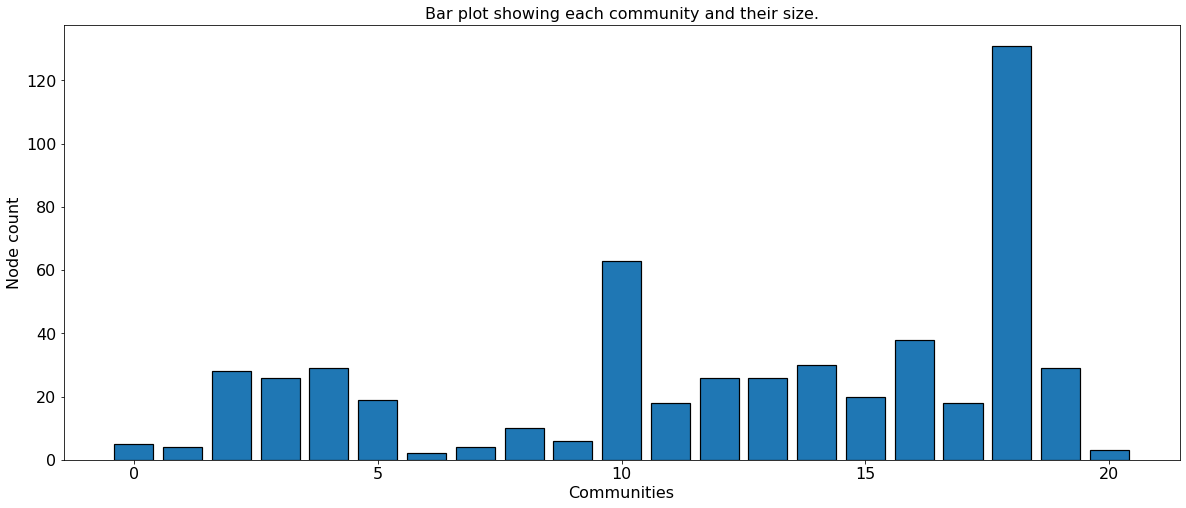

In [48]:
dist = []
dist = [all_partitions.count(x) for x in communities]

plt.figure(figsize = (20,8))
plt.bar(communities, dist, edgecolor='black', linewidth=1.2)
plt.xticks(fontsize=16)
plt.title('Bar plot showing each community and their size.',fontsize=16)
plt.xlabel('Communities', fontsize=16)
plt.ylabel('Node count',fontsize=16)
_ = plt.yticks(fontsize=16)

The plot shows that the community sizes vary greatly.

#### For the 5 largest communites, create TF-IDF based rankings of words in each community

Generating a list of the top five communities

In [49]:
dist = []
dist = [[x, all_partitions.count(x)] for x in communities]

top_five = sorted(dist, key = lambda i: i[1], reverse=True)[0:5]
top_five_com = []
for x in top_five:
    top_five_com.append(x[0])

#### Q: There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.

The TF represents the frequency of the word and was calculated by finding the number of occurrences of each word in each community and dividing by the length of that community. The IDF is the inverse document frequency and was calculated by taking the log of the total number of communities divided by the number of communities that the word occurs in. 

In [50]:
communities_list = [[] for i in range(0, len(communities))]

In [51]:
stops = list(set(stopwords.words("english")))
header_pattern = '==+.*?==+'

wnl = nltk.WordNetLemmatizer()


#Loop through all character names in our dataframe 
for node in UG_gc.nodes:
    name = node.replace(' ','_')
    with open('./character_pages/'+name+'.txt') as f:
        text = f.read()
        f.close()

    #Filtering out the headers of sections 
    new_text = re.sub(header_pattern,'',text)

    #Excluding character names 
    for n in G.nodes:
        n_plural = n+'s'
        new_text = re.sub(n,'',new_text)
        new_text = re.sub(n_plural,'',new_text)

    #Tokenizing the text with WordPunctTokenizer()
    tokens = []
    tokens = WordPunctTokenizer().tokenize(new_text)

    #For each token, only include if it's not punctuation, if it's not a stopword and if it is longer than one letter when lemmatized
    #Saving results in the corresponding community array, results are saved in lowercase and lemmatized
    for token in tokens:
        if token.isalpha() and token.lower() not in str(stops).lower() and len(wnl.lemmatize(token.lower())) != 1:
            communities_list[partition[node]].append(wnl.lemmatize(token.lower()))

Saving the count for each community

In [52]:
community_df = pd.DataFrame({'word': [],'count': [],'community':[],'tf':[],'idf':[]})

for i in range(len(communities_list)):
    for w in list(set(communities_list[i])):
        new_row = {'word':w, 'count':communities_list[i].count(w),'community':'community'+str(i)}
        community_df = community_df.append(new_row, ignore_index=True)

In [53]:
#Total number of communities
n = len(communities) 

#for w in community_df.word:
for index, row in community_df.iterrows():
    com_nums = community_df.loc[community_df.word == row['word'], 'word'].count()
    community_df.at[index,'idf'] = math.log10(n/com_nums)
    com_count = community_df.loc[community_df.community == row['community']].count()
    community_df.at[index,'tf'] = row['count']/com_count.word
community_df['tf-idf'] = community_df['tf'] * community_df['idf']    

#### Q: List the 5 top words for each community according to TF.

In [54]:
for i in top_five:
    print('Top five words according to TF for community',i[0] , ':' ,list(community_df[community_df['community'] == 'community' + str(i[0])].sort_values(by=['tf'], ascending=False)['word'])[0:5])

Top five words according to TF for community 18 : ['botw', 'ref', 'cite', 'term', 'link']
Top five words according to TF for community 10 : ['botw', 'term', 'link', 'ref', 'shrine']
Top five words according to TF for community 16 : ['botw', 'ref', 'term', 'cite', 'link']
Top five words according to TF for community 14 : ['botw', 'ref', 'term', 'cite', 'link']
Top five words according to TF for community 4 : ['botw', 'ref', 'term', 'link', 'plural']


#### Q: List the 5 top words for each community accourding to TF-IDF. 

In [55]:
for i in top_five:
    print('Top five words according to TF-IDF for community',i[0] , ':' ,list(community_df[community_df['community'] == 'community' + str(i[0])].sort_values(by=['tf-idf'], ascending=False)['word'])[0:5])

Top five words according to TF-IDF for community 18 : ['tmc', 'gerudo', 'chief', 'kara', 'horse']
Top five words according to TF-IDF for community 10 : ['monk', 'cac', 'shrine', 'sheikah', 'ostracism']
Top five words according to TF-IDF for community 16 : ['pumpkin', 'sheikah', 'heirloom', 'fortified', 'yiga']
Top five words according to TF-IDF for community 14 : ['zora', 'ley', 'domain', 'ruta', 'sasan']
Top five words according to TF-IDF for community 4 : ['twwhd', 'coh', 'sshd', 'desc', 'pitem']


#### Q: Are these words more descriptive of the community than just the TF? Justify your answer.

Yes they are a lot more descriptive using TF-IDF rather than only TF. When looking at the results from the TF it can be seen that a lot of the words are the same (botW, ref, term, cite), so they are not characteristic for the community. When using the TF-IDF the words that are in all of the communites don't show up leaving only the words that describes each community.

# Part 4: Sentiment of communities

Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities. More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:

    * We name each community by its three most connected characters.
    * Average the average sentiment of the nodes in each community to find a community level sentiment.
    
Here's what you need to do (repeat these steps and report your results for both LabMT and VADER):

    * Calculate and store sentiment for every character
    * Create a histogram of all character's associated sentiments.
    * What are the 10 characters with happiest and saddest pages?
    
Now, compute the sentiment of communities:

    * What are the three happiest communities according to the LabMT wordlist approach? What about VADER?
    * What are the three saddest communities according to the LabMT wordlist approach? What about VADER?
    * Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods.
    * Explain the difference between the two methods and compare the results you have obtained above.
    * What is the advantage of using a rule-based method over the dictionary-based approach?

## LabMT

Obtaining the LabMT tokens

In [56]:
file = open('./LabMT.csv')
csvreader = csv.reader(file)
LabMT_list = []
for row in csvreader:
        LabMT_list.append(row)
LabMT_list=LabMT_list[1:]

Creating a function to calculate the sentiment score from the LabMT

In [57]:
def calc_sent(words_list, sentiment_list):
    sent_score = []
    for word in words_list:
        for sentiment in sentiment_list:
            if sentiment[0] == word:
                sent_score.append(float(sentiment[2]))
    return np.mean(sent_score)

#### Calculate and store sentiment for every character

Removing bad words from the text

In [58]:
tokens = []
with open('./CharactersDialogue.json') as json_file:
    data = json.load(json_file)
    
for key, value in data.items():
    for i, sentence in enumerate(value):
        value[i] = re.sub("[^a-zA-Z0-9, \ , \']+", "", sentence)

Some characters were included in the CharactersDialogue file that did not exist in the giant component, they were either removed because they were isolates or were part of small clusters that were not connected to the giant component.

In [59]:
names=[]
for node in UG_gc.nodes():
    names.append(node)

missing_char = []
char = list(data.keys())
for node in char:
    if node not in names:
        missing_char.append(node)

In [ ]:
wnl = nltk.WordNetLemmatizer()

LabMT = []

char = list(data.keys())
#Going throug each character in the dictionary in the Dialogue file
for node in char:
    if node not in missing_char:   
        word = data[node]
        tokens = []
        tokenizer = []
        #Tokenizing each word
        for w in word:
            token = WordPunctTokenizer().tokenize(w)
            tokens = tokens + token

        final_tokens = []
        #Lemmatizing each token and putting to lower case
        for token in tokens:
            final_tokens.append(wnl.lemmatize(token.lower()))
        
        #Calculating average score for each node using the LabMT wordlist and adding as an attribute
        char_sent_score = calc_sent(final_tokens, LabMT_list)
        LabMT.append(char_sent_score)
        UG_gc.nodes[node]['LabMT'] = char_sent_score

#### Q: Create a histogram of all character's associated sentiments.

In [ ]:
plt.figure(figsize = (20,8))
plt.hist(LabMT, bins = 30, edgecolor='black', linewidth=1.2)
plt.show
plt.ylabel('Number count',fontsize=16)
plt.xlabel('Average sentiment value',fontsize=16)
plt.xticks(fontsize=16)
plt.title('Histogram of the average sentiment of each character using LabMT.',fontsize=16)
_ = plt.yticks(fontsize=16)

#### Q: What are the 10 characters with happiest and saddest pages?

In [ ]:
all_LabMT = []
for node in char:
    if node not in missing_char: 
        all_LabMT.append([node, UG_gc.nodes[node]['LabMT']])
        
happiest_char = sorted(all_LabMT, key = lambda i: i[1], reverse=True)[0:10]
saddest_char = sorted(all_LabMT, key = lambda i: i[1], reverse=False)[0:10]
print("The happiest characters are: ")
print([x[0] for x in happiest_char])
print("The saddest characters are: ")
print([x[0] for x in saddest_char])

## Vader

Function to calculate the sentiment score using Vader

In [ ]:
def calc_sent_Vader(word_list):
    sent_score = []
    analyzer = SentimentIntensityAnalyzer()
    for word in word_list:
        vs = analyzer.polarity_scores(word)
        sent_score.append(vs['compound'])
    return np.mean(sent_score)         

#### Q: Calculate and store sentiment for every character

Removing bad characters from the text

In [ ]:
tokens = []
with open('./CharactersDialogue.json') as json_file:
    data = json.load(json_file)



for key, value in data.items():
    for i, sentence in enumerate(value):
        value[i] = re.sub("[^a-zA-Z0-9!#$%&'()*+,-./:;<=>?@[\]^_`{|}~, \ , \']+", "", sentence)

In [ ]:
wnl = nltk.WordNetLemmatizer()


Vader = []
char = list(data.keys())
for node in char:
    if node not in missing_char:
        word = data[node]

        char_sent_score = calc_sent_Vader(word)
        Vader.append(char_sent_score)
        UG_gc.nodes[node]['Vader'] = char_sent_score

#### Q: Create a histogram of all character's associated sentiments.

In [ ]:
plt.figure(figsize = (20,8))
plt.hist(Vader, bins = 30, edgecolor='black', linewidth=1.2)
plt.show
plt.ylabel('Number count',fontsize=16)
plt.xlabel('Average sentiment value',fontsize=16)
plt.xticks(fontsize=16)
plt.title('Histogram of the average sentiment of each character using VADER.',fontsize=16)
_ = plt.yticks(fontsize=16)

#### Q: What are the 10 characters with happiest and saddest pages?

In [ ]:
all_Vader = []
for node in char:
    if node not in missing_char: 
        all_Vader.append([node, UG_gc.nodes[node]['Vader']])
        
happiest_char = sorted(all_Vader, key = lambda i: i[1], reverse=True)[0:10]
saddest_char = sorted(all_Vader, key = lambda i: i[1], reverse=False)[0:10]
print("The happiest characters are: ")
print([x[0] for x in happiest_char])
print("The saddest characters are: ")
print([x[0] for x in saddest_char])

## Communities

Average sentiment for each community according to LabMT

In [ ]:
LabMT_sent = np.zeros(len(communities))
LabMT_sent_std = np.zeros(len(communities))
char = list(data.keys())
temp_deg = []
LabMT_names = ['' for i in range(0, len(communities))]

for com in communities:
    temp_com = []
    temp_deg = []
    for node in char:
        if node not in missing_char: 
            if partition[node] == com:
                temp_com.append(UG_gc.nodes[node]['LabMT'])
                temp_deg.append([node, UG_gc.degree(node)])
    if temp_com == []:
        mean_temp_com = 0
    else:
        mean_temp_com = np.mean(temp_com)
    top_names = sorted(temp_deg, key = lambda i: i[1], reverse=True)[0:3]
    if top_names != []:
        temp_name = top_names[0][0]
        top_names = top_names[1:]
        for name in top_names:
            temp_name = temp_name  + ' - ' + name[0]
    else:
        temp_name = ''
    LabMT_sent[com] = mean_temp_com
    LabMT_sent_std[com] = np.std(temp_com)
    LabMT_names[com] = temp_name

Average sentiment for each community according to Vader

In [ ]:
Vader_sent = np.zeros(len(communities))
Vader_sent_std = np.zeros(len(communities))
char = list(data.keys())
temp_deg = []
Vader_names = ['' for i in range(0, len(communities))]

for com in communities:
    temp_com = []
    temp_deg = []
    for node in char:
        if node not in missing_char: 
            if partition[node] == com:
                temp_com.append(UG_gc.nodes[node]['Vader'])
                temp_deg.append([node, UG_gc.degree(node)])
    if temp_com == []:
        mean_temp_com = 0
    else:
        mean_temp_com = np.mean(temp_com)
        
    top_names = sorted(temp_deg, key = lambda i: i[1], reverse=True)[0:3]
    if top_names != []:
        temp_name = top_names[0][0]
        top_names = top_names[1:]
        for name in top_names:
            temp_name = temp_name  + ' - ' + name[0]
    else:
        temp_name = ''
        
    Vader_sent[com] = mean_temp_com
    Vader_sent_std[com] = np.std(temp_com)
    Vader_names[com] = temp_name
    

#### Q: What are the three happiest communities according to the LabMT wordlist approach? What about VADER?

In [ ]:
highest_LabMT = sorted(LabMT_sent, reverse=True)[0:3]
highest_vader = sorted(Vader_sent, reverse=True)[0:3]

LabMT_sent = list(LabMT_sent)

com1 = LabMT_sent.index(highest_LabMT[0])
com2 = LabMT_sent.index(highest_LabMT[1])
com3 = LabMT_sent.index(highest_LabMT[2])

print('Three happiest communities according to LabMT are:')
print(LabMT_names[com1])
print(LabMT_names[com2])
print(LabMT_names[com3])

Vader_sent = list(Vader_sent)

com1 = Vader_sent.index(highest_vader[0])
com2 = Vader_sent.index(highest_vader[1])
com3 = Vader_sent.index(highest_vader[2])

print('Three happiest communities according to Vader are:')
print(Vader_names[com1])
print(Vader_names[com2])
print(Vader_names[com3])

#### Q: What are the three saddest communities according to the LabMT wordlist approach? What about VADER?

In [ ]:
lowest_LabMT = sorted(LabMT_sent, reverse=False)[0:3]
lowest_Vader = sorted(Vader_sent, reverse=False)[0:3]



LabMT_sent = list(LabMT_sent)

com1 = LabMT_sent.index(lowest_LabMT[0])
com2 = LabMT_sent.index(lowest_LabMT[1])
com3 = LabMT_sent.index(lowest_LabMT[2])

print('Three saddest communities according to LabMT are:')
print(LabMT_names[com1])
print(LabMT_names[com2])
print(LabMT_names[com3])

Vader_sent = list(Vader_sent)

com1 = Vader_sent.index(lowest_Vader[0])
com2 = Vader_sent.index(lowest_Vader[1])
com3 = Vader_sent.index(lowest_Vader[2])

print('Three saddest communities according to Vader are:')
print(Vader_names[com1])
print(Vader_names[com2])
print(Vader_names[com3])

#### Q: Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods.

In [ ]:
plt.figure(figsize = (20,10))
plt.bar(communities, LabMT_sent ,yerr = LabMT_sent_std, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(communities, LabMT_names, fontsize=16, rotation = 90)
plt.yticks(fontsize=16)
plt.ylabel('Average sentiment',fontsize=16)
_ = plt.title('Bar plot showing the average sentiment of each community using LabMT')

In [ ]:
plt.figure(figsize = (20,10))
plt.bar(communities, Vader_sent ,yerr = Vader_sent_std, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(communities, Vader_names, fontsize=16, rotation = 90)
plt.yticks(fontsize=16)
plt.ylabel('Average sentiment',fontsize=16)
_ = plt.title('Bar plot showing the average sentiment of each community using Vader', fontsize = 20)

The bar plot using LabMT shows that the sentiment is quite similar for most communities, with most of the values between 5 - 6, and a very low standard deviation. However, the bar plot using the Vader method shows a much more change in the sentiment and a very high standard deviation for most communities. Most of the values are though on the side and none of the values are quite high.

#### Q: Explain the difference between the two methods and compare the results you have obtained above.

The LabMT method only looks at the words, and returns a happiness_average number which is from 1.3 to 8.5
The Vader method also looks at punctuations, and returns a number between -1 to 1 where -1 is the most negartive emotion and 1 is the most positive emotion. The Vader method also analyses the entire sentence, and therefore catches the context of the sentence.

#### Q: What is the advantage of using a rule-based method over the dictionary-based approach?

Words in the LabMT wordlist:
not: 3.86
happy: 8.3

When using the dictionary-based approach, like the LabMT, each token is analysed, therefore losing the context of the sentence. For example 'happy' would give the happiness score of 8.3 while 'not happy' would give 6.08, which is still a fairly high score on the scale. Adding the word 'not' in front of happy changes the meaning of the word a lot, but does not change the score as much as it should. 

In [ ]:
word1 = 'happy'
word2 = 'not happy'
analyzer = SentimentIntensityAnalyzer()
vs1 = analyzer.polarity_scores(word1)
vs2 = analyzer.polarity_scores(word2)
print('The polarity score for happy: ', vs1)
print('The polarity score for not happy: ', vs2)

When using the Vader method, which is a rule-based method, there is a lot more drop in the happiness score, since addig the not in front changes the meaning of the word happy.